# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRegressor

## Column Descriptions
- `Item_Identifier`	- Unique product ID
- `Item_Weight` - Weight of product
- `Item_Fat_Content` - Whether the product is low fat or not
- `Item_Visibility` - The % of total display area of all products in a store allocated to the particular product
- `Item_Type` -	The category to which the product belongs
- `Item_MRP` -	Maximum Retail Price (list price) of the product
- `Outlet_Identifier` -	Unique store ID
- `Outlet_Establishment_Year` -	The year in which store was established
- `Outlet_Size` - The size of the store in terms of ground area covered
- `Outlet_Location_Type` - The type of city in which the store is located
- `Outlet_Type` - Whether the outlet is just a grocery store or some sort of supermarket
- `Item_Outlet_Sales` -	Sales of the product in the particulat store. This is the outcome variable to be predicted.

In [2]:
sales_df = pd.read_csv('train.csv')
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
sales_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [4]:
nulls = sales_df.isnull().sum()
nulls = (nulls/sales_df.shape[0])*100

In [5]:
nulls

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

`Item_Weight` and `Outlet_Size` have 17% and 28% missing values respectively. By dropping the null values we are loosing an important chunk of data, instead, missing values of `Item_Weight` are replaced with the mean.

`Outlet_Size`, being a categorical variable, is replaced with the mode. After concluding that there is no correlation between among the different `Outlet_Size` options (i.e. High, Medium, Small) and `Outlet_Type`. 

---

## Data Cleaning

In [6]:
sales_df['Item_Weight'].fillna(sales_df['Item_Weight'].mean(), inplace=True)

In [7]:
crosstab = pd.crosstab(index=sales_df['Outlet_Size'], columns=sales_df['Outlet_Type'])
crosstab

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,932,0,0
Medium,0,930,928,935
Small,528,1860,0,0


### Chi-squared test
Based on the chi-square tests there is no correlation among categorical variables `Outlet_Size` and `Outlet_Type`. The missing value will be replaced with most frequent outlet size per outlet type.

In [8]:
from scipy.stats import chi2_contingency

chi_sq = chi2_contingency(crosstab)
chi_sq[1]

0.0

In [9]:
missing_values = sales_df['Outlet_Size'].isnull()

In [10]:
most_frequent = sales_df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
most_frequent

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [11]:
sales_df.loc[missing_values, 'Outlet_Size'] = sales_df.loc[missing_values,'Outlet_Type'].apply(lambda x: most_frequent[x])

In [12]:
def generalize(ser, match_name, default=None, regex=False, case=False):
    """ Search a series for text matches.
    Based on code from https://www.metasnake.com/blog/pydata-assign.html

    ser: pandas series to search
    match_name: tuple containing text to search for and text to use for normalization
    default: If no match, use this to provide a default value, otherwise use the original text
    regex: Boolean to indicate if match_name contains a  regular expression
    case: Case sensitive search

    Returns a pandas series with the matched value

    """
    seen = None
    for match, name in match_name:
        mask = ser.str.contains(match, case=case, regex=regex)
        if seen is None:
            seen = mask
        else:
            seen |= mask
        ser = ser.where(~mask, name)
    if default:
        ser = ser.where(seen, default)
    else:
        ser = ser.where(seen, ser.values)
    return ser



patterns = [('LF', 'Low Fat'), ('low fat', 'Low Fat'), ('Reg', 'Regular')]

In [13]:
sales_df.Item_Fat_Content = generalize(sales_df.Item_Fat_Content, patterns)

In [14]:
sales_df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

---

## EDA (Exploratory Data Analysis)

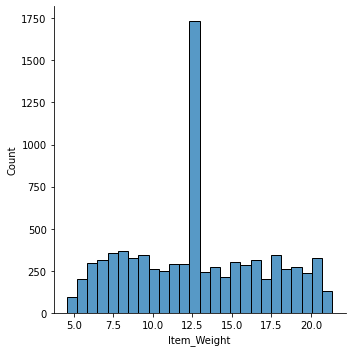

In [15]:
sns.displot(sales_df, x='Item_Weight')

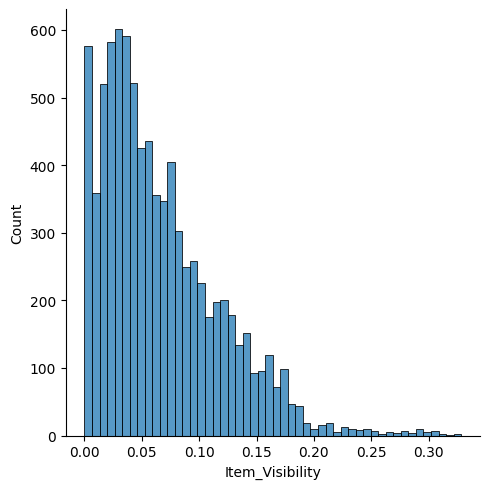

In [16]:
sns.displot(sales_df, x='Item_Visibility', kind='hist')

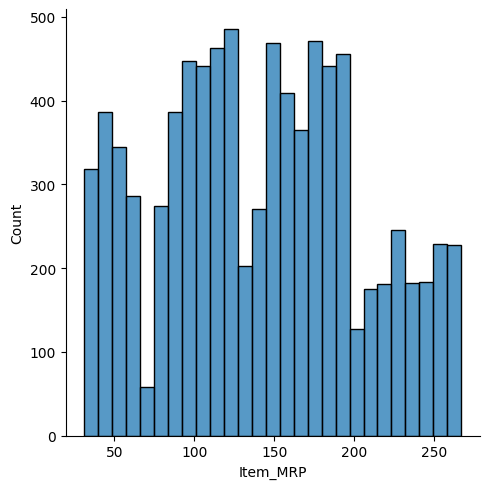

In [17]:
sns.displot(sales_df, x='Item_MRP', kind='hist')

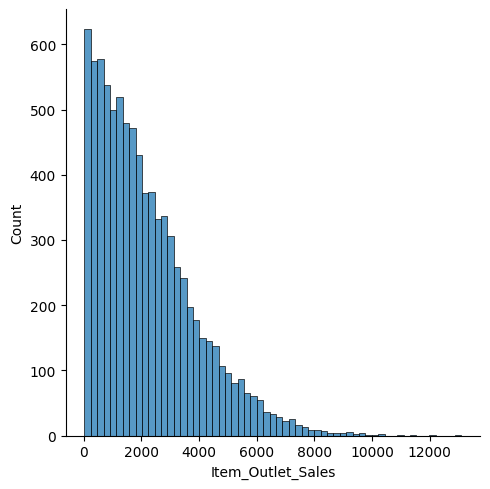

In [18]:
sns.displot(sales_df, x='Item_Outlet_Sales', kind='hist')

In [19]:
sales_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

---

## Label Encoding

Encoding categorical variables into numerical values

In [20]:
encoder = LabelEncoder()

In [21]:
sales_df['Item_Identifier'] = encoder.fit_transform(sales_df['Item_Identifier'])

sales_df['Item_Fat_Content'] = encoder.fit_transform(sales_df['Item_Fat_Content'])

sales_df['Item_Type'] = encoder.fit_transform(sales_df['Item_Type'])

sales_df['Outlet_Identifier'] = encoder.fit_transform(sales_df['Outlet_Identifier'])

sales_df['Outlet_Size'] = encoder.fit_transform(sales_df['Outlet_Size'])

sales_df['Outlet_Type'] = encoder.fit_transform(sales_df['Outlet_Type'])

sales_df['Outlet_Location_Type'] = encoder.fit_transform(sales_df['Outlet_Location_Type'])

---

## Machine Learning Model Training

XGBoost Regressor

### Splitting Features and Target

In [22]:
X = sales_df.iloc[0:,0:11]
y = sales_df['Item_Outlet_Sales']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Model Fit

In [24]:
regressor = XGBRegressor()

regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

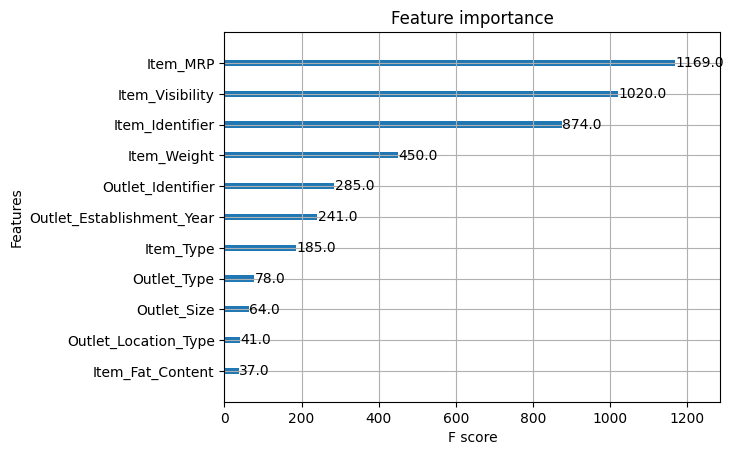

In [25]:
import xgboost as xgb
xgb.plot_importance(regressor, ax=plt.gca())

### Sales Prediction

In [26]:
# prediction on training data
train_prediction = regressor.predict(X_train)

# R^2 value
r2_train = metrics.r2_score(y_train, train_prediction)

# MSE (Mean Squared Error)
mse_train = metrics.mean_squared_error(y_train, train_prediction)

In [27]:
print('Train data')
print('R squared: ', r2_train)
print('MSE: ', mse_train)

Training data
R squared:  0.8639680373364909
MSE:  390007.5229903313


In [28]:
# prediction on test data
test_prediction = regressor.predict(X_test)

# R^2 value
r2_test = metrics.r2_score(y_test, test_prediction)

# MSE (Mean Squared Error)
mse_test = metrics.mean_squared_error(y_test, test_prediction)

In [29]:
print('Test data')
print('R squared: ', r2_test)
print('MSE: ', mse_test)

Test data
R squared:  0.5233136709735687
MSE:  1471566.3111618883


### Visualizing Sales Prediction vs List Price

Text(0.5, 1.0, 'Test Data')

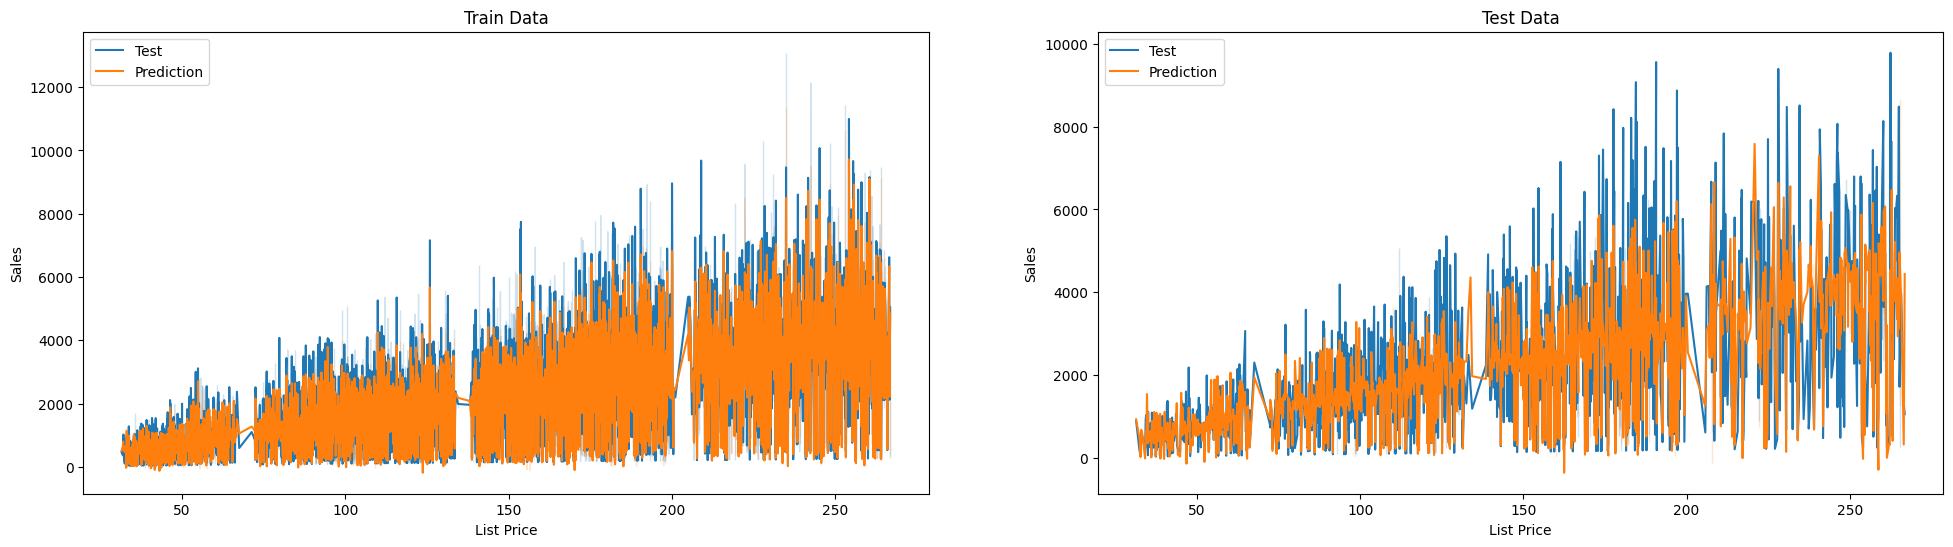

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (24, 6))
sns.lineplot(x=X_train.Item_MRP, y=y_train, ax=ax1, label='Test')
sns.lineplot(x=X_train.Item_MRP, y=train_prediction, ax=ax1, label='Prediction')
ax1.set_ylabel('Sales')
ax1.set_xlabel('List Price')
ax1.set_title('Train Data')
sns.move_legend(ax1, "upper left")
sns.lineplot(x=X_test.Item_MRP, y=y_test, ax=ax2, label='Test')
sns.lineplot(x=X_test.Item_MRP, y=test_prediction, ax=ax2, label='Prediction')
ax2.set_ylabel('Sales')
ax2.set_xlabel('List Price')
ax2.set_title('Test Data')

### Visualizing Sales Prediction vs Item Visibility in Store

Text(0.5, 1.0, 'Test Data')

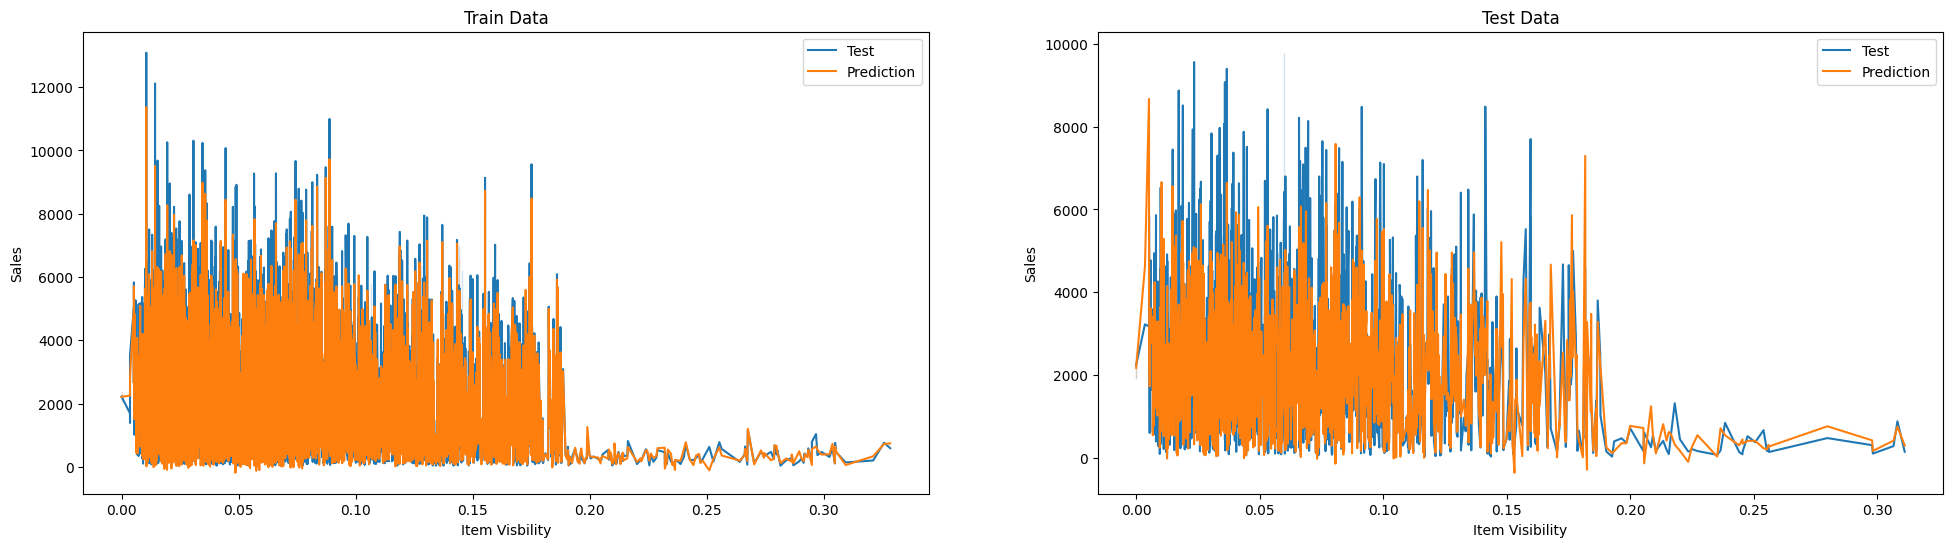

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (24, 6))
sns.lineplot(x=X_train.Item_Visibility, y=y_train, ax=ax1, label='Test')
sns.lineplot(x=X_train.Item_Visibility, y=train_prediction, ax=ax1, label='Prediction')
ax1.set_ylabel('Sales')
ax1.set_xlabel('Item Visbility')
ax1.set_title('Train Data')
sns.lineplot(x=X_test.Item_Visibility, y=y_test, ax=ax2, label='Test')
sns.lineplot(x=X_test.Item_Visibility, y=test_prediction, ax=ax2, label='Prediction')
ax2.set_ylabel('Sales')
ax2.set_xlabel('Item Visibility')
ax2.set_title('Test Data')